Note that HMR requires the bounding box of the person in the image. The best performance is obtained when max length of the person in the image is roughly 150px.

When only the image path is supplied, it assumes that the image is centered on a person whose length is roughly 150px.

Alternatively, you can supply output of the openpose to figure out the bbox and the right scale factor.

Sample usage:

In [1]:
# # On images on a tightly cropped image around the person
# python -m demo --img_path data/im1963.jpg
# python -m demo --img_path data/coco1.png

# # On images, with openpose output
# python -m demo --img_path data/random.jpg --json_path data/random_keypoints.json

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
from absl import flags
import numpy as np

import skimage.io as io
import tensorflow as tf

from src.util import renderer as vis_util
from src.util import image as img_util
from src.util import openpose as op_util
import src.config
from src.RunModel import RunModel

In [3]:
flags.DEFINE_string('img_path', 'data/im1963.jpg', 'Image to run')
flags.DEFINE_string(
    'json_path', None,
    'If specified, uses the openpose output to crop the image.')

In [4]:
def visualize(img, proc_param, joints, verts, cam):
    """
    Renders the result in original image coordinate frame.
    """
    cam_for_render, vert_shifted, joints_orig = vis_util.get_original(
        proc_param, verts, cam, joints, img_size=img.shape[:2])

    # Render results
    skel_img = vis_util.draw_skeleton(img, joints_orig)
#     rend_img_overlay = renderer(
#         vert_shifted, cam=cam_for_render, img=img, do_alpha=True)
#     rend_img = renderer(
#         vert_shifted, cam=cam_for_render, img_size=img.shape[:2])
#     rend_img_vp1 = renderer.rotated(
#         vert_shifted, 60, cam=cam_for_render, img_size=img.shape[:2])
#     rend_img_vp2 = renderer.rotated(
#         vert_shifted, -60, cam=cam_for_render, img_size=img.shape[:2])

    import matplotlib.pyplot as plt
    # plt.ion()
    plt.figure(1)
    plt.clf()
    plt.subplot(231)
    plt.imshow(img)
    plt.title('input')
    plt.axis('off')
    plt.subplot(232)
    plt.imshow(skel_img)
    plt.title('joint projection')
    plt.axis('off')
#     plt.subplot(233)
#     plt.imshow(rend_img_overlay)
#     plt.title('3D Mesh overlay')
#     plt.axis('off')
#     plt.subplot(234)
#     plt.imshow(rend_img)
#     plt.title('3D mesh')
#     plt.axis('off')
#     plt.subplot(235)
#     plt.imshow(rend_img_vp1)
#     plt.title('diff vp')
#     plt.axis('off')
#     plt.subplot(236)
#     plt.imshow(rend_img_vp2)
#     plt.title('diff vp')
#     plt.axis('off')
#     plt.draw()
#     plt.show()
#     # import ipdb
#     # ipdb.set_trace()

In [5]:
def preprocess_image(img_path, json_path=None):
    img = io.imread(img_path)
    if img.shape[2] == 4:
        img = img[:, :, :3]

    if json_path is None:
        if np.max(img.shape[:2]) != config.img_size:
            print('Resizing so the max image size is %d..' % config.img_size)
            scale = (float(config.img_size) / np.max(img.shape[:2]))
        else:
            scale = 1.
        center = np.round(np.array(img.shape[:2]) / 2).astype(int)
        # image center in (x,y)
        center = center[::-1]
    else:
        scale, center = op_util.get_bbox(json_path)

    crop, proc_param = img_util.scale_and_crop(img, scale, center,
                                               config.img_size)

    # Normalize image to [-1, 1]
    crop = 2 * ((crop / 255.) - 0.5)

    return crop, proc_param, img

In [6]:
config = flags.FLAGS

remaining_args = config([sys.argv[0]] + [flag for flag in sys.argv if flag.startswith("--")])
assert(remaining_args == [sys.argv[0]])

In [7]:
# Using pre-trained model, change this to use your own.
config.load_path = src.config.PRETRAINED_MODEL

config.batch_size = 1

# renderer = vis_util.SMPLRenderer(face_path=config.smpl_face_path)

# main(config.img_path, config.json_path)


In [8]:
# def main(img_path, json_path=None):
img_path=config.img_path
json_path=config.json_path
sess = tf.Session()
model = RunModel(config, sess=sess)

W0308 09:45:49.778436  6808 deprecation_wrapper.py:119] From C:\_Files\MyProjects\ASDS_3\Photo_Wake-Up\src\HMR\TensorFlow\src\RunModel.py:42: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0308 09:45:55.147192  6808 deprecation_wrapper.py:119] From C:\_Files\MyProjects\ASDS_3\Photo_Wake-Up\src\HMR\TensorFlow\src\models.py:77: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



Iteration 0


W0308 09:45:56.190569  6808 deprecation.py:323] From C:\_Files\MyProjects\ASDS_3\Photo_Wake-Up\src\HMR\TensorFlow\src\tf_smpl\batch_lbs.py:55: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Iteration 1
Reuse is on!
Iteration 2
Reuse is on!


W0308 09:45:59.548091  6808 deprecation_wrapper.py:119] From C:\_Files\MyProjects\ASDS_3\Photo_Wake-Up\src\HMR\TensorFlow\src\RunModel.py:70: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0308 09:46:00.062002  6808 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Restoring checkpoint C:\_Files\MyProjects\ASDS_3\Photo_Wake-Up\src\HMR\TensorFlow\src\..\models\model.ckpt-667589..


In [9]:
input_img, proc_param, img = preprocess_image(img_path, json_path)
# Add batch dimension: 1 x D x D x 3
input_img = np.expand_dims(input_img, 0)

# Theta is the 85D vector holding [camera, pose, shape]
# where camera is 3D [s, tx, ty]
# pose is 72D vector holding the rotation of 24 joints of SMPL in axis angle format
# shape is 10D shape coefficients of SMPL
joints, verts, cams, joints3d, theta = model.predict(input_img, get_theta=True)

# visualize(img, proc_param, joints[0], verts[0], cams[0])

Resizing so the max image size is 224..


In [13]:
def get_original(proc_param, verts, cam, joints, img_size):
    img_size = proc_param['img_size']
    undo_scale = 1. / np.array(proc_param['scale'])

    cam_s = cam[0]
    cam_pos = cam[1:]
    principal_pt = np.array([img_size, img_size]) / 2.
    flength = 500.
    tz = flength / (0.5 * img_size * cam_s)
    trans = np.hstack([cam_pos, tz])
    vert_shifted = verts + trans

    start_pt = proc_param['start_pt'] - 0.5 * img_size
    final_principal_pt = (principal_pt + start_pt) * undo_scale
    cam_for_render = np.hstack(
        [np.mean(flength * undo_scale), final_principal_pt])

    # This is in padded image.
    # kp_original = (joints + proc_param['start_pt']) * undo_scale
    # Subtract padding from joints.
    margin = int(img_size / 2)
    kp_original = (joints + proc_param['start_pt'] - margin) * undo_scale

    return cam_for_render, vert_shifted, kp_original

C:\_Files\MyProjects\ASDS_3\Photo_Wake-Up\src\HMR\TensorFlow\src\util\renderer.py:329: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):


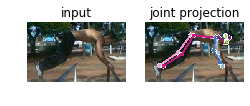

In [12]:
# renderer = vis_util.SMPLRenderer(face_path=config.smpl_face_path)

visualize(img, proc_param, joints[0], verts[0], cams[0])

# img, proc_param, joints, verts, cam = img, proc_param, joints[0], verts[0], cams[0]

# cam_for_render, vert_shifted, joints_orig = vis_util.get_original(
#         proc_param, verts, cam, joints, img_size=img.shape[:2])

In [ ]:
# print('proc params: ', proc_param)
# print('joints: ', joints[0])
# print('vertices; ', verts[0])
# print('cameras: ', cams[0])
# print('theta: ', theta)

In [14]:
print('shape of joints: ', joints[0].shape)
print('shape of 3D joints: ', joints3d[0].shape)
print('shape of vertices; ', verts[0].shape)
print('shape of cameras: ', cams[0].shape)
print('shape of theta: ', theta[0].shape)

shape of joints:  (19, 2)
shape of 3D joints:  (19, 3)
shape of vertices;  (6890, 3)
shape of cameras:  (3,)
shape of theta:  (85,)


In [15]:
print('overall shape of joints: ', joints.shape)
print('overall shape of 3D joints: ', joints3d.shape)
print('overall shape of vertices; ', verts.shape)
print('overall shape of cameras: ', cams.shape)
print('overall shape of theta: ', theta.shape)

overall shape of joints:  (1, 19, 2)
overall shape of 3D joints:  (1, 19, 3)
overall shape of vertices;  (1, 6890, 3)
overall shape of cameras:  (1, 3)
overall shape of theta:  (1, 85)


In [ ]:
# num_cam = 3
# num_theta = 72

In [ ]:
# cams = theta[:, :num_cam]
# poses = theta[:, num_cam:(num_cam + num_theta)]
# shapes = theta[:, (num_cam + num_theta):]

In [ ]:
# cams

In [ ]:
# poses